# Example of fit with Correlation Matrix on Data 

https://stackoverflow.com/questions/44810437/problems-with-curve-fit-fitting-highly-correlated-data

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
def f(x, a, b):
    return a + b*x

In [3]:
x = np.array([1, 2, 3])
y = np.array([2, 0.75, 0])
sig = np.array([[2.0, 1.3, 0.0],
                [1.3, 2.0, 1.3],
                [0.0, 1.3, 2.0]])

In [4]:
params, pcov = curve_fit(f, x, y, sigma=sig)

In [5]:
y_errors = f(x, *params) - y

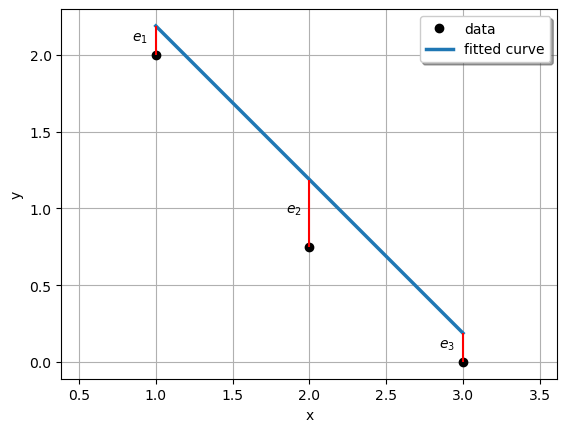

In [7]:
plt.plot(x, y, 'ko', label="data")
plt.plot(x, f(x, *params), linewidth=2.5, label="fitted curve")
plt.vlines(x, y, f(x, *params), 'r')

for k in range(3):
    plt.annotate(text=r"$e_{%d}$" % (k+1), xy=(x[k]-0.05, y[k]+0.5*y_errors[k]), ha='right')

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.legend(framealpha=1, shadow=True)
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

    chisq = r.T @ inv(sigma) @ r.


In [8]:
r = y - f(x, *params)

In [9]:
r

array([-0.1875, -0.4375, -0.1875])

In [14]:
np.linalg.inv(sig)

array([[ 1.86290323, -2.09677419,  1.36290323],
       [-2.09677419,  3.22580645, -2.09677419],
       [ 1.36290323, -2.09677419,  1.86290323]])

In [15]:
r.T

array([-0.1875, -0.4375, -0.1875])

In [18]:
r.T

array([-0.1875, -0.4375, -0.1875])

In [20]:
r @ np.linalg.inv(sig) @ r

0.15625000000000022

# To fit with errors on X and Y

https://scicomp.stackexchange.com/questions/33166/what-is-a-good-library-in-python-for-correlated-fits-in-both-the-x-and-y-dat

In [21]:
import numpy as np
from scipy.optimize import least_squares



class Fitter(object):
    """
    Orthogonal distance regression (ODR) fitter object.
    """

    def __init__(self,):
        pass

    def Model(self, function):
        """
        Set the model to fit to.
        """
        self.model = function

    def Beta0(self, init_beta):
        """
        Set the initial parameters.
        """
        self.beta0 = np.array(init_beta)
        self.bs = len(init_beta)

    def Data(self, xdata, ydata, sigmax=None, sigmay=None, covx=None, covy=None):
        """
        Input the x and y data, as well as the errors if they exist.
        """
        if (len(xdata) != len(ydata)):
            raise ValueError("x and y data must have same shape")
        self.x = xdata
        self.y = ydata
        self.xs = len(xdata)
        self.ys = len(ydata)
        self.delta = np.zeros(shape=(self.xs,))
        if (sigmax is not None) and (sigmay is not None):
            Omega = np.block([[np.diag(1./sigmay**2), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.diag(1./sigmax**2)]])
        elif (sigmax is not None) and (sigmay is None):
            Omega = np.block([[np.eye(self.xs), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.diag(1./sigmax**2)]])
        elif (sigmax is None) and (sigmay is not None):
            Omega = np.block([[np.diag(1./sigmay**2), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.eye(self.xs)]])
        elif (covx is not None) and (covy is not None):
            Omega = np.block([[np.linalg.inv(covy), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.linalg.inv(covx)]])
        elif (covx is None) and (covy is not None):
            Omega = np.block([[np.linalg.inv(covy), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.eye(self.xs)]])
        elif (covx is not None) and (covy is None):
            Omega = np.block([[np.eye(self.xs), np.zeros((self.ys, self.ys))],
                              [np.zeros((self.xs, self.xs)), np.linalg.inv(covx)]])
        else:
            Omega = np.eye(2*self.xs)

        self.L = np.linalg.cholesky(Omega)
        assert np.allclose(Omega, self.L.dot(self.L.transpose()))


    def Residuals(self, z):
        """
        Calculates the sum of residuals for ODR.
        """
        para = z[:self.bs]
        arguments = z[self.bs:]

        rx = arguments
        ry = (self.model(self.x + rx, *para) - self.y)
        r = np.hstack((ry, rx))

        return np.dot(r, self.L)

    def Run(self,):
        """
        Runs the fitter.
        """
        self.whole = np.append(self.beta0, self.delta)
        self.out = least_squares(self.Residuals, self.whole, method='lm')
        self.chi2 = np.sum(self.out.fun**2) / float(len(self.x)-len(self.beta0))